In [2]:
suppressMessages(library("edgeR"))
suppressMessages(library("limma"))
library("SmartSVA")
library("qvalue")

library(fgsea)
library(tidyverse)
#library('sigPathway')
library(data.table)
library(ggplot2)

library(tidyverse)

library(tidyr)
library(igraph)

library(graphlayouts)

library(tidygraph)

library(ggraph)


Loading required package: sva

Loading required package: mgcv

Loading required package: nlme

This is mgcv 1.8-41. For overview type 'help("mgcv-package")'.

Loading required package: genefilter

Loading required package: BiocParallel

Loading required package: isva

Loading required package: qvalue

Loading required package: fastICA

Loading required package: JADE

Loading required package: RSpectra

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::collapse() 

In [3]:
pathways <- gmtPathways("/Users/lmartin/Documents/2019/RNA_analysis/pathway_analysis/h.all.v6.2.symbols.gmt")
pathways_c2 <- gmtPathways("/Users/lmartin/Documents/2019/RNA_analysis/pathway_analysis/c2.all.v7.1.symbols.gmt")

pathways_kegg <- gmtPathways("/Users/lmartin/Documents/2019/RNA_analysis/pathway_analysis/c2.cp.kegg.v6.2.symbols.gmt")

pathways_c3 <- gmtPathways("/Users/lmartin/Documents/2020/RNA_analysis/c3.all.v7.4.symbols.gmt")

pathways_c4 <- gmtPathways("/Users/lmartin/Documents/2019/RNA_analysis/pathway_analysis/c4.cgn.v6.2.symbols.gmt")

pathways_c6 <- gmtPathways("/Users/lmartin/Documents/2019/RNA_analysis/pathway_analysis/c6.all.v6.2.symbols.gmt")

pathways_c5 <- gmtPathways("/Users/lmartin/Documents/2019/RNA_analysis/pathway_analysis/c5.all.v6.2.symbols.gmt")

pathways_biocarta <- gmtPathways("/Users/lmartin/Documents/2020/RNA_analysis/c2.cp.biocarta.v7.4.symbols.gmt")

pathways_pid <- gmtPathways("/Users/lmartin/Documents/2020/RNA_analysis/c2.cp.pid.v7.4.symbols.gmt")

pathways_in_estrogen <- gmtPathways("/Users/lmartin/Documents/2022/HALLMARK_ESTROGEN_RESPONSE_EARLY.gmt")

pathways_kahn <- gmtPathways("/Users/lmartin/Documents/2022/Geneset_HALLMARK_C2CP_RB1_Deurte.gmt")

vantveer_up <- gmtPathways("/Users/lmartin/Documents/2022/VANTVEER_BREAST_CANCER_ESR1_UP.v7.5.1.gmt")

vantveer_dn <- gmtPathways("/Users/lmartin/Documents/2022/VANTVEER_BREAST_CANCER_ESR1_DN.v7.5.1.gmt")


Warning message in readLines(gmt.file):
“incomplete final line found on '/Users/lmartin/Documents/2022/HALLMARK_ESTROGEN_RESPONSE_EARLY.gmt'”
Warning message in readLines(gmt.file):
“incomplete final line found on '/Users/lmartin/Documents/2022/VANTVEER_BREAST_CANCER_ESR1_UP.v7.5.1.gmt'”
Warning message in readLines(gmt.file):
“incomplete final line found on '/Users/lmartin/Documents/2022/VANTVEER_BREAST_CANCER_ESR1_DN.v7.5.1.gmt'”


## SVA script

In [4]:

RunDiffExprAnalysisLimma <- function(counts.df, var.df, genes.df=NULL, use.sva=TRUE, n.sv=NULL) {
    # Computes differential expression using a combination of SmartSVA and voom-limma
    #
    # Args:
    #   counts.df: data.frame with read counts (#genes x #samples)
    #   var: variable of interest
    #   genes.df: data.frame mapping gene IDs to gene names
    #   n.sv: number of surrogates for SVA. Automatically determined if NULL.
    #
    # Returns:
    #   voom-limma output augmented with Storey q-values
    #   SVA surrogate variables
    stopifnot(dim(unique(var.df))[1]>1 && dim(var.df)[2]==1)
    var <- colnames(var.df)[1]
    var2 <- colnames(var.df)[2]

    design <- cbind(1, var.df)

    # apply edgeR normalization (TMM) to counts
    dge <- DGEList(counts=counts.df)
    dge <- calcNormFactors(dge)

    # define model
    
    mod <- model.matrix(as.formula(paste0('~', var)), var.df)
    if (use.sva) {
        cat("  * running SmartSVA\n")
        v <- voom(dge, design=mod)  # run on transformed counts
        print(v)

        Y.r <- t(resid(lm(as.formula(paste0('t(v$E) ~ ', var)), data=var.df)))

        n.sv <- EstDimRMT(Y.r, FALSE)$dim + 1
        cat(paste0("  * SVs: ", n.sv, "\n"))
        sv.obj <- smartsva.cpp(as.matrix(v$E), mod, mod0=NULL, n.sv=n.sv, alpha=1, B=200, VERBOSE=TRUE)

        # update model to include SVs
        mod <- model.matrix(as.formula(paste0('~', var, '+sv.obj$sv')), var.df)  # intercept, var, SVs
    }

    # run limma
    v <- voom(dge, design=mod)
    fit <- lmFit(v, design=mod)
    fit <- eBayes(fit)

    print(summary(decideTests(fit)))
    print(design)
    res <- topTable(fit, coef=ncol(design), n=Inf,sort.by='none')

    # calculate q-values
    Q <- qvalue(res[, "P.Value"])
    res[, 'qval'] <- signif(Q$qvalue, 6)
    cat(paste0("Differentially expressed genes at 0.05 FDR: ", sum(res[, 'qval']<=0.05), "\n"))
    if (!is.null(genes.df)) {
        res[, 'gene_name'] <- genes.df[row.names(res), 'Description']
        #res[, 'gene_name'] <- genes.df[row.names(res), 'X']
        res <- res[, colnames(res)[c(8,1:7)]]
    }

    if (use.sva) {
        return(list("res"=res, "C"=sv.obj$sv))
    } else {
        return(res)
    }
}

## covariates

In [77]:
autopsy_patients <- c(rep(1547,7), rep(1113,5), rep(1035,9),rep(1326,8),rep(1078,10),
                 rep(1598,13), rep(2389, 18), rep(1045,15), rep(1644,5), 
                  rep(1002,17), rep(2974,11),rep(2819,12), rep(1558,14),rep(2542, 11))

 
#kmt2c_groups <-c(rep("Other", 22), "KMT2C", rep("Other", 29), 
#           rep("KMT2C",18), rep("Other",60), 
#                rep('Other',14), rep('KMT2C',11))

kmt2c_groups <-c("KMT2C", "KMT2C", "Other","Other", "KMT2C", rep("Other", 16), rep("KMT2C",8), rep("Other", 23), 
           rep("KMT2C",18), rep("Other",80), rep('KMT2C',2), rep("Other",3))


kmt2c_var <- data.frame(kmt2c_groups)

In [6]:
autopsy_liver <- c(rep(1,7), 0, rep(1,4), rep(0, 6), rep(1,3), rep(0,3),rep(1,5),0,rep(1,4),0,rep(1,8),
                  rep(0, 5), rep(1,2),0,1,rep(0,18),rep(1,4),0,0,rep(1,9),rep(0,28),rep(1,3),rep(0,3),
                  1,1,0,1,rep(0,4),1,1,0,rep(1,3),rep(0,7),rep(1,5),rep(0,8),1,1)

In [22]:
kmt2c_var

kmt2c_groups
<chr>
KMT2C
KMT2C
Other
KMT2C
KMT2C
KMT2C
Other
Other
Other


## input file

In [23]:

file <- c('CDK_counts_processed_092023_for_limma.tsv')
data <- read.delim(file,header=T)
data_subset <- data[rowSums(data[2:156])>10,]
counts.df <- data_subset[2:156]
genes_df <- data[1]
counts.df

,RP.1700_T001137.10_v3_RNA_OnPrem,RP.1700_T001137.1_v3_RNA_OnPrem,RP.1700_T001137.2_v2_RNA_OnPrem,RP.1700_T001137.3_v2_RNA_OnPrem,RP.1700_T001137.4_v3_RNA_OnPrem,RP.1700_T001137.5_v3_RNA_OnPrem,RP.1700_T001137.6_v3_RNA_OnPrem,RP.1700_T00655.11_v2_RNA_OnPrem,RP.1700_T00655.13_v2_RNA_OnPrem,RP.1700_T00655.15_v2_RNA_OnPrem,⋯,RP.1700_T03142.11_v1_RNA_OnPrem,RP.1700_T03142.12_v1_RNA_OnPrem,RP.1700_T03142.13_v1_RNA_OnPrem,RP.1700_T03142.17_v1_RNA_OnPrem,RP.1700_T03142.18_v1_RNA_OnPrem,RP.1700_T03142.1_v1_RNA_OnPrem,RP.1700_T03142.2_v1_RNA_OnPrem,RP.1700_T03142.3_v1_RNA_OnPrem,RP.1700_T03142.8_v1_RNA_OnPrem,RP.1700_T03142.9_v1_RNA_OnPrem
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,739,1204,712,272,173,609,142,1013,837,1295,⋯,796,509,867,474,815,1340,389,1100,144,141
2,12,24,18,25,6,8,8,14,1,3,⋯,71,167,116,128,11,302,134,240,112,67
3,46,391,32,19,50,17,9,25,4,26,⋯,141,367,295,73,403,1547,201,269,10,21
4,48,120,90,5,3,55,6,21,7,23,⋯,41,50,32,17,40,53,3,39,8,2
5,13,18,19,14,4,1,2,4,2,0,⋯,47,28,98,3,12,55,10,23,4,5
6,1011,2030,557,729,829,687,643,2109,152,85,⋯,4832,4931,5231,1422,3693,14258,2415,4925,2994,2030
7,0,16,5,0,4,0,0,6,13,2,⋯,14,8,0,0,18,0,0,0,0,0
8,470,822,635,58,106,162,49,157,467,1050,⋯,116,404,175,30,94,1492,26,58,10,4
9,6275,12770,2914,351,686,1184,443,4899,4402,6496,⋯,5243,1026,5001,629,5040,3044,390,553,29,102


## limma voom no SVA

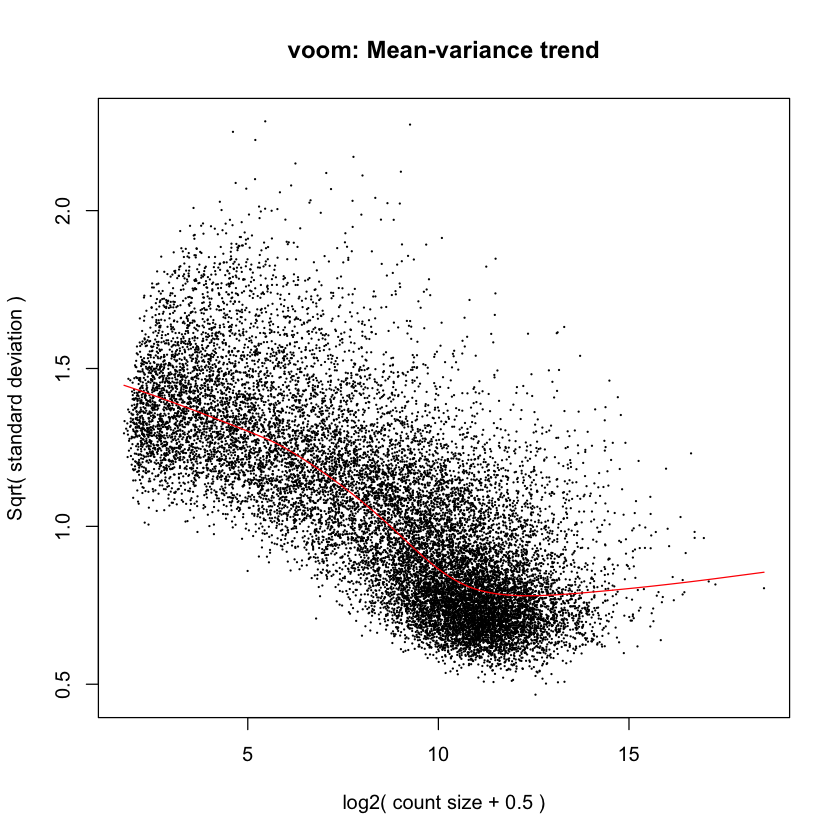

In [78]:
x <- DGEList(counts=counts.df, group=kmt2c_groups)

genenames <- genes_df
x$genes <- genenames
x <- calcNormFactors(x)

cpm <- cpm(x)
lcpm <- cpm(x, log=TRUE)

keep.exprs <- filterByExpr(x, group=kmt2c_groups)
x <- x[keep.exprs,, keep.lib.sizes=FALSE]

design <- model.matrix(~0+kmt2c_groups +autopsy_patients+autopsy_liver)
v <- voom(x,design,plot=TRUE)

In [38]:
corfit <- duplicateCorrelation(v, design, block=autopsy_patients)
corfit

$consensus.correlation
[1] 0.4979587

$cor
[1] 0.4979587

$atanh.correlations
    [1]  1.032181e+00  1.089843e+00  1.082584e+00  1.051801e+00  9.139172e-01
    [6]  7.732773e-01  1.622431e-01  6.013246e-01  5.788125e-01  6.501056e-01
   [11]  7.441867e-01  6.152525e-01  1.061428e+00  1.261887e+00  3.004676e-01
   [16]  3.134965e-01  3.014449e-01  9.621206e-01  7.292480e-01  6.884448e-01
   [21]  4.098875e-01  6.787484e-01  4.409567e-01  6.685651e-01  8.594374e-01
   [26]  4.445408e-01  7.675815e-01  5.670741e-01  3.161260e-01  5.135790e-01
   [31]  6.926742e-01  5.530842e-01  7.992602e-01  3.981272e-01  8.355517e-01
   [36]  6.747343e-01  9.236348e-01  7.820796e-01  7.266770e-01  2.204513e-01
   [41]  5.993149e-01  2.784100e-01  5.553028e-01  8.572680e-01  1.506756e-01
   [46]  2.572336e-01  8.976116e-01  9.321453e-01  4.614673e-01  4.817094e-01
   [51]  5.571309e-01  6.206536e-01  3.623853e-01  7.673529e-01  5.550414e-01
   [56]  3.010296e-01  7.983314e-01  4.262953e-01  3.091897e-01  4.499437e-01
   [61]  5.687359e-01  5.906068e-01  4.116232e-01  7.628510e-01  4.326851e-01
   [66]  3.694097e-01  5.499142e-01  7.960421e-01  6.683260e-01  7.295035e-01
   [71]  2.650630e-01  9.300079e-01  4.902853e-01  3.942133e-01  7.191708e-01
   [76]  1.576951e-01  1.124659e+00  6.732538e-01  3.311034e-01  6.917708e-01
   [81]  7.070786e-01  7.407579e-01  2.812906e-01  7.181130e-01  2.613065e-01
   [86]  3.883592e-01  4.397802e-01  5.152083e-01  8.850048e-01  6.321161e-01
   [91]  7.668450e-01  9.651521e-01  1.000572e+00  2.899200e-01  5.997370e-01
   [96]  4.644951e-01  4.695315e-01  8.113073e-01  5.650685e-01  4.661934e-01
  [101]  4.099095e-01  6.522217e-01  5.089816e-01  3.687371e-01  4.389919e-01
  [106]  3.229673e-01  5.902231e-01  3.186659e-01  4.202026e-01  2.716586e-01
  [111]  5.552908e-01  2.677675e-01  2.345411e-01  4.362671e-01  5.773690e-01
  [116]  7.359207e-01  2.940777e-01  3.753976e-01  4.946743e-01  2.584284e-01
  [121]  2.136641e-01  7.012424e-01  4.356660e-01  7.597781e-01  3.413531e-01
  [126]  5.921070e-01  4.854113e-01  1.028484e+00  6.203756e-01  2.115627e-01
  [131]  5.703426e-01  7.281499e-01  4.909363e-01  4.335965e-01  8.389122e-01
  [136]  9.893153e-01  9.553978e-01  6.163732e-01  3.153715e-01  8.147658e-01
  [141]  3.160246e-01  7.810586e-01  2.260949e-01  5.536836e-01  4.109081e-01
  [146]  3.436608e-01  9.262818e-01  9.915874e-02  4.224406e-01  5.029406e-01
  [151]  4.066778e-01  4.711590e-01  4.192281e-01  5.545093e-01  5.648498e-01
  [156]  3.876445e-01  6.214505e-01  5.550359e-01  9.594177e-01  3.886586e-01
  [161]  4.078484e-01  4.589382e-01  3.628044e-01  4.634033e-01  2.759355e-01
  [166]  2.705243e-01  5.401003e-01  5.374853e-01  3.846216e-01  6.238021e-01
  [171]  1.005513e+00  1.609648e-01  4.921654e-01  3.197829e-01  5.660404e-01
  [176]  4.972714e-01  3.989530e-01  3.230979e-01  3.345885e-02  3.988683e-01
  [181]  3.565471e-01  4.681363e-01  3.554389e-01  5.822936e-01  1.048103e+00
  [186]  7.588196e-01  4.660134e-01  6.974636e-01  7.557454e-01  7.758392e-01
  [191]  5.026195e-01  3.702072e-01  3.270691e-01  4.038597e-01  3.874850e-01
  [196]  4.702293e-01  5.318337e-01  2.677144e-01  2.286836e-01  1.181505e+00
  [201]  1.047498e+00  1.127112e+00  2.092011e-01  2.858789e-01  6.978272e-01
  [206]  6.177280e-01  4.996981e-01  3.497777e-01  4.105431e-01  2.132287e-01
  [211]  4.907651e-01  4.620879e-01  4.962145e-01  5.536190e-01  6.754112e-01
  [216]  5.318914e-01  3.451863e-01  4.759730e-01  9.175722e-02  5.674760e-01
  [221]  4.882040e-01  4.099901e-01  3.069158e-01  2.455505e-01  4.150649e-01
  [226]  6.537542e-01  1.822889e-01  2.055698e-01  6.836458e-01  5.504658e-01
  [231]  6.527678e-01  7.804901e-01  8.599671e-01  1.485816e-01  6.980009e-01
  [236]  6.117281e-01  2.079732e-01  3.359529e-01  6.204460e-01  4.701683e-01
  [241]  3.845787e-01  6.248857e-01  4.109149e-01  4.406329e-01  4.575867e-01
  [246]  4.132135e-01  8.079315e-01  3.750663e-01  3.249671e-01  3.520333e-01
  [251]  5.805568e-01 

In [79]:
fit <- lmFit(v, design, block=autopsy_patients, correlation=corfit$consensus)

contr.matrix <- makeContrasts(kmt2cvother = kmt2c_groupsKMT2C - kmt2c_groupsOther, levels=colnames(design))

vfit <- contrasts.fit(fit,contr.matrix)
efit <- eBayes(vfit)
summary(decideTests(efit))

       kmt2cvother
Down             0
NotSig       17105
Up               3

In [80]:
kmt2c.v.other <- topTreat(efit, coef=1, n=Inf)
head(kmt2c.v.other,20)

,Description,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
8496,FAM21B,2.6504760,-0.1384845,5.715694,5.444749e-08,0.0007041414,6.0446238
9572,AP000439.3,4.1151773,-2.6167556,5.630192,8.231721e-08,0.0007041414,4.7354118
16652,CASK,0.9435313,5.3215124,4.679199,6.232300e-06,0.0355407283,3.6620878
16068,TBX1,-2.4393371,1.6146547,-4.356445,2.394103e-05,0.1023957849,1.8655868
4293,LRRC37A15P,2.4651441,-2.4376010,4.283731,3.212264e-05,0.1079728891,0.6194045
12187,SYNM,-2.1767826,4.5123177,-4.242653,3.786751e-05,0.1079728891,2.0243605
4457,GLRB,1.7705841,1.9125883,4.166862,5.114817e-05,0.1099411768,1.5132562
3522,CCDC58,-0.6708194,4.5903276,-4.161126,5.231702e-05,0.1099411768,1.7371898
14863,ZFP82,-1.0486009,2.9001577,-4.106915,6.470188e-05,0.1099411768,1.4574201


In [93]:
write.csv(kmt2c.v.other, 'kmt2c_vs_other_no_sva_pat_and_liver_covar_091223.csv')

## GSEA

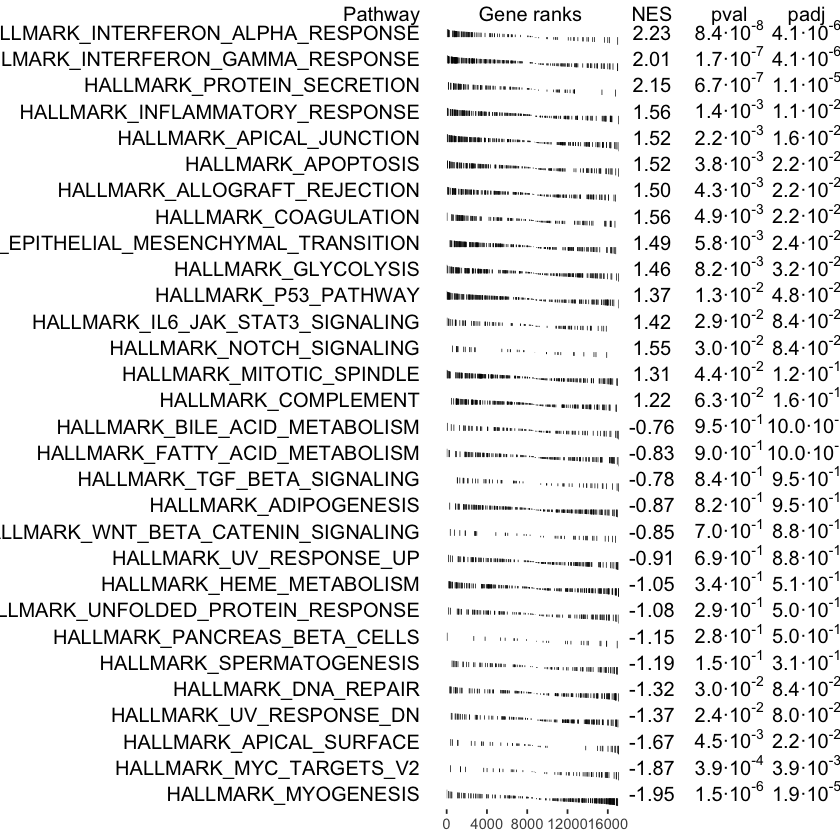

In [81]:
ranktest <- data.frame(kmt2c.v.other$Description, kmt2c.v.other$t)
names(ranktest) <- c("Symbol", "stat")
ranks <- deframe(ranktest)

fgsea_hallmark <- fgsea(pathway=pathways, stats=ranks, minSize=10, maxSize=300)
topPathwaysUp <- fgsea_hallmark[ES > 0][head(order(pval), n=15), pathway]
topPathwaysDown <- fgsea_hallmark[ES < 0][head(order(pval), n=15), pathway]
topPathways <- c(topPathwaysUp, rev(topPathwaysDown))
plotGseaTable(pathways[topPathways], ranks, fgsea_hallmark, 
              gseaParam=0.5, colwidths = c(20, 8, 3, 4, 3))

In [95]:
fwrite(fgsea_hallmark, file="kmt2c_vs_not_no_sva_pat_and_liver_covar_091223_fgseaRes.tsv", sep="\t", sep2=c("", " ", ""))



## with SVA

In [82]:
df <- as.data.frame(design)
Yr <- t(resid(lm(t(v$E) ~ kmt2c_groups +autopsy_patients+autopsy_liver, data=df)))

dof <- EstDimRMT(Yr, FALSE)$dim
smart.nsv <- dof + 1
#
# Run smartSVA
sv.obj <- smartsva.cpp(v$E, mod=design, mod0=NULL, n.sv=smart.nsv, B=200, VERBOSE=TRUE)

Iteration (out of 200 ):
1   0 
2   0.570694492779882 
3   0.455277992363334 
4   0.900458279409531 
5   0.461500256749289 
6   0.461539484672483 
7   0.463590377054781 
8   0.463482415769064 
9   0.461074444241372 
10   0.461298890370331 
11   0.460649018709612 
12   0.461215629786759 
13   0.463542736558021 
14   0.463252727789825 
15   0.462340118873465 
16   0.46243093370666 
17   0.466518538977023 
18   0.465536938848504 
19   0.466295552465057 
20   0.928815604389396 
21   0.925658016716285 
22   0.931917947465536 
23   0.931140201307731 
24   0.933215253970502 
25   0.933803207793297 
26   0.936601626137378 
27   0.93605559726022 
28   0.933972557512651 
29   0.937811632028359 
30   0.937236351018579 
31   0.932543706017593 
32   0.933056470004006 
33   0.939330247280838 
34   0.940647039160083 
35   0.937966510017772 
36   0.935940040525288 
37   0.938624796446857 
38   0.93884787864234 
39   0.939103284683604 
40   0.939403265761259 
41   0.936619652145396 
42   0.936320484009

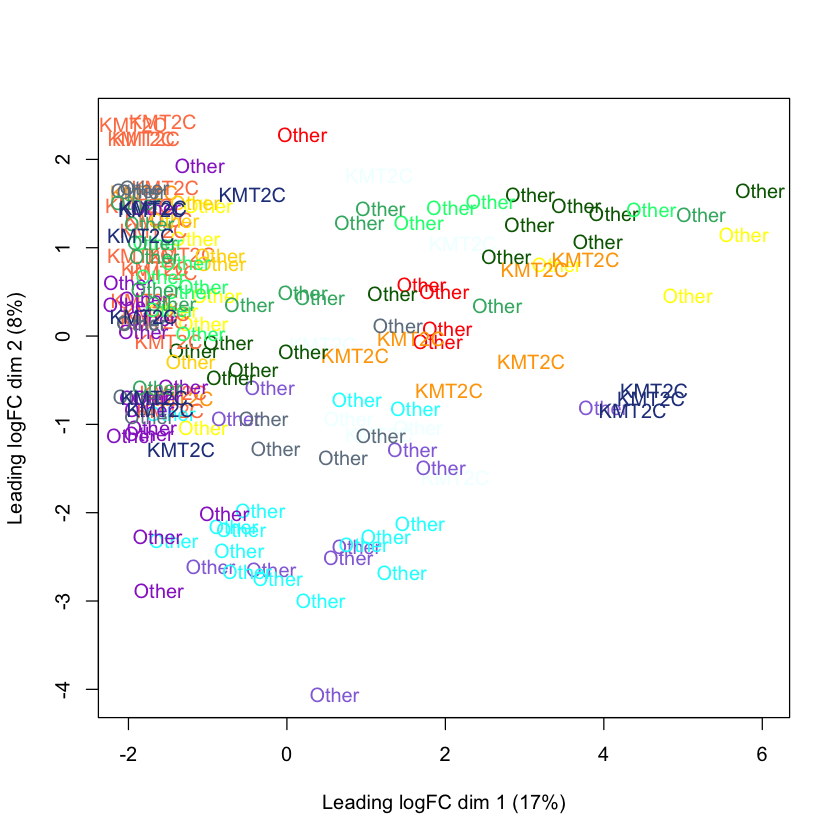

In [30]:
autopsy_patients_colors <- c(rep('azure',7), rep('red',5), rep('yellow',9),rep('orange',8),rep('mediumpurple',10),
                 rep('darkgreen',13), rep('coral', 18), rep('cyan',15), rep('gold',5), 
                  rep('darkorchid',17), rep('springgreen1',11),rep('slategray',12),rep('mediumseagreen',14),
                            rep('royalblue4',12))


plotMDS(x, labels=kmt2c_groups, col=autopsy_patients_colors)

In [83]:
svs <- sv.obj$sv
colnames(svs) <- paste0('sv', seq(1, smart.nsv))
svDesign <- cbind(design, svs)
head(svDesign)

,kmt2c_groupsKMT2C,kmt2c_groupsOther,autopsy_patients,autopsy_liver,sv1,sv2,sv3,sv4,sv5,sv6,⋯,sv14,sv15,sv16,sv17,sv18,sv19,sv20,sv21,sv22,sv23
1,1,0,1547,1,0.01659793,-0.030691480,0.023361258,0.115608043,0.10661048,0.051972284,⋯,0.022666356,-0.015953373,0.13911796,-0.05811286,0.047757291,0.17365784,0.076780861,0.11076392,-0.007058441,-0.054869039
2,1,0,1547,1,0.07926413,-0.007089526,0.025242908,0.098588875,0.08882521,0.003633204,⋯,0.008531297,-0.073000935,0.07487492,-0.07675845,-0.003715255,0.01630458,0.141810912,0.03334716,0.017730350,-0.002867764
3,0,1,1547,1,-0.04411647,-0.071440357,0.002139818,0.117527145,0.14301567,-0.006770770,⋯,-0.046844634,0.010112743,0.10649084,-0.06444275,0.001809797,0.10378398,0.178831297,0.04138537,-0.091712935,-0.031284546
4,0,1,1547,1,-0.04750967,-0.006488435,-0.060256439,0.192185787,0.11465439,-0.047870201,⋯,-0.140732457,0.001505628,-0.09032883,0.13987211,0.089008372,-0.05722209,-0.009098376,0.23689770,0.096147475,-0.101491350
5,1,0,1547,1,0.14855085,0.018576072,-0.024889720,-0.005298582,0.01958795,-0.002494727,⋯,0.118752167,0.067799761,0.07267792,0.07686911,-0.033037580,0.02306325,0.034859539,0.02473578,0.203211879,0.109928600
6,0,1,1547,1,-0.05424736,-0.089916934,-0.025289923,0.096125421,0.16860005,0.010095320,⋯,-0.052784051,0.056836760,0.17985983,-0.02099372,0.073661142,0.13142878,0.071800970,0.05831590,-0.034042068,-0.097541037


In [142]:
svDesign[,1:9]

,kmt2c_groupsKMT2C,kmt2c_groupsOther,autopsy_patients,autopsy_liver,sv1,sv2,sv3,sv4,sv5
1,1,0,1547,1,0.016597930,-0.0306914798,0.023361258,0.115608043,0.106610483
2,1,0,1547,1,0.079264127,-0.0070895260,0.025242908,0.098588875,0.088825213
3,0,1,1547,1,-0.044116468,-0.0714403571,0.002139818,0.117527145,0.143015674
4,0,1,1547,1,-0.047509671,-0.0064884349,-0.060256439,0.192185787,0.114654385
5,1,0,1547,1,0.148550853,0.0185760723,-0.024889720,-0.005298582,0.019587953
6,0,1,1547,1,-0.054247362,-0.0899169338,-0.025289923,0.096125421,0.168600049
7,0,1,1547,1,-0.009123435,-0.0730310602,-0.018869361,0.125794380,0.142261034
8,0,1,1113,0,0.157429815,-0.1483246878,-0.049017807,-0.116688141,-0.147989204
9,0,1,1113,1,0.012035786,-0.0551568283,-0.013968120,0.117590687,-0.176792680
10,0,1,1113,1,0.062189485,-0.0608213220,-0.066815872,0.058719935,-0.152380062


In [207]:
testSV <- svDesign[,c('kmt2c_groupsKMT2C','kmt2c_groupsOther','autopsy_patients',
            'autopsy_liver','sv1','sv2','sv3','sv4','sv5','sv12','sv16','sv20')]
# svDesign[,1:9] is maybe best so far

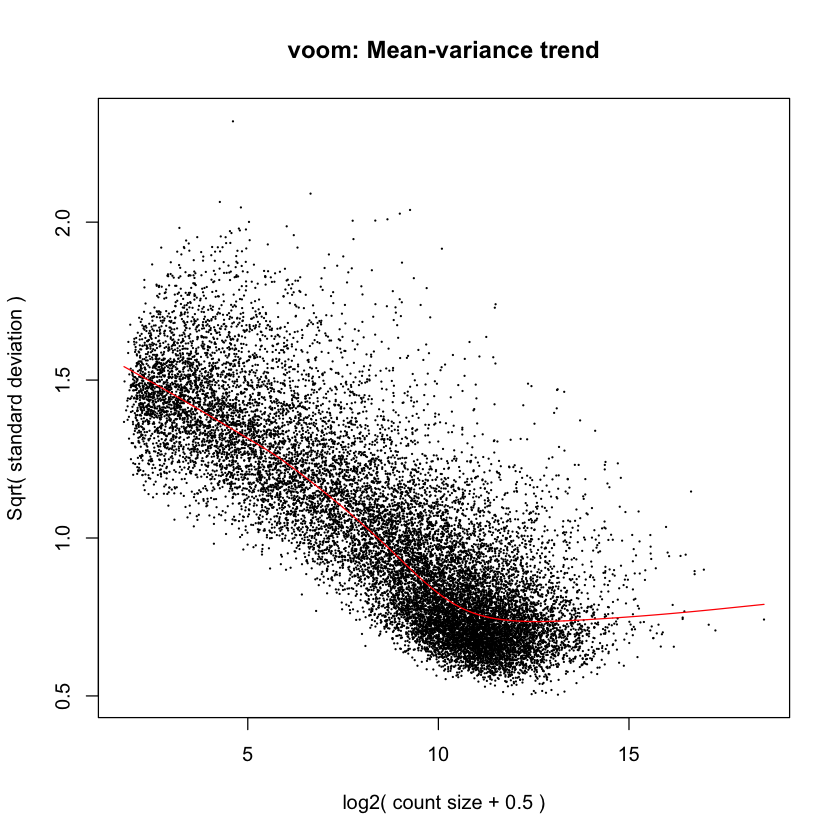

In [208]:
v <- voom(counts=x,
          design=testSV,
          plot=TRUE,
          block=autopsy_patients,
          correlation=corfit$consensus)

In [209]:
fit <- lmFit(v, testSV, block=autopsy_patients, correlation=corfit$consensus)

contr.matrix <- makeContrasts(kmt2cvother = kmt2c_groupsKMT2C - kmt2c_groupsOther, levels=colnames(testSV))

vfit <- contrasts.fit(fit,contr.matrix)
efit <- eBayes(vfit)
summary(decideTests(efit))

       kmt2cvother
Down            61
NotSig       17028
Up              19

In [210]:
kmt2c.v.other <- topTreat(efit, coef=1, n=Inf)
head(kmt2c.v.other,40)

,Description,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
11233,TTC6,-1.6754357,3.3615346,-6.687952,4.341186e-10,0.0000074269,12.599059
3906,MFI2-AS1,-2.0814463,2.2424876,-5.868545,2.773534e-08,0.0002372481,8.426246
3522,CCDC58,-0.8066666,4.5903276,-5.547769,1.298341e-07,0.0007404007,7.260637
12498,RRN3P3,-1.3425325,3.0494136,-5.403853,2.551578e-07,0.0010913100,6.585849
3534,SEC22A,-0.6879673,4.3265454,-5.268149,4.776847e-07,0.0013734760,6.039667
1977,BCYRN1,-2.4799063,3.6971816,-5.266325,4.816961e-07,0.0013734760,6.030841
10147,STK38L,0.8479751,5.7845630,5.213494,6.132068e-07,0.0014606015,5.762478
9572,AP000439.3,3.9366928,-2.6167556,5.189792,6.830028e-07,0.0014606015,4.097125
6172,ESR1,-2.3676909,6.8223325,-4.961918,1.894854e-06,0.0034810087,4.705490


In [156]:
write.csv(kmt2c.v.other, 'kmt2c_vs_other_sva_changing_svs_110623.csv')

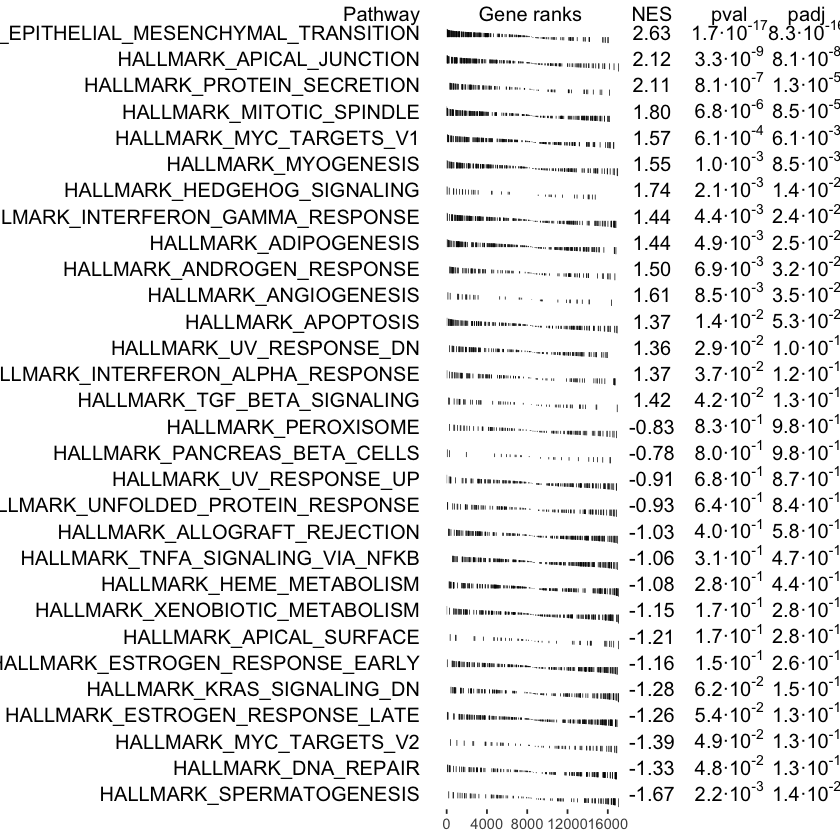

In [211]:
ranktest <- data.frame(kmt2c.v.other$Description, kmt2c.v.other$t)
names(ranktest) <- c("Symbol", "stat")
ranks <- deframe(ranktest)

fgsea_hallmark <- fgsea(pathway=pathways, stats=ranks, minSize=10, maxSize=300)
topPathwaysUp <- fgsea_hallmark[ES > 0][head(order(pval), n=15), pathway]
topPathwaysDown <- fgsea_hallmark[ES < 0][head(order(pval), n=15), pathway]
topPathways <- c(topPathwaysUp, rev(topPathwaysDown))
plotGseaTable(pathways[topPathways], ranks, fgsea_hallmark, 
              gseaParam=0.5, colwidths = c(20, 8, 3, 4, 3))

In [191]:
fwrite(fgsea_hallmark, file="kmt2c_vs_not_sva_relabel_110623_changing_svs_no_sv11_fgseaRes.tsv", sep="\t", sep2=c("", " ", ""))



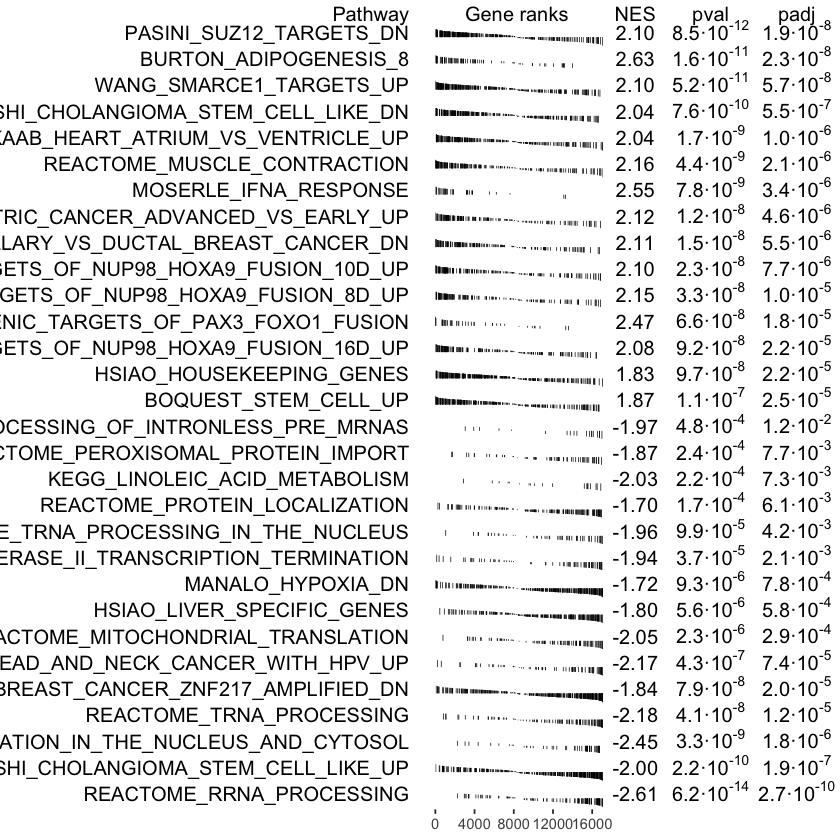

In [88]:
fgsea_c2 <- fgsea(pathway = pathways_c2, stats=ranks, minSize=10, maxSize=300)

topPathwaysUp <- fgsea_c2[ES > 0][head(order(pval), n=15), pathway]
topPathwaysDown <- fgsea_c2[ES < 0][head(order(pval), n=15), pathway]
topPathways <- c(topPathwaysUp, rev(topPathwaysDown))
plotGseaTable(pathways_c2[topPathways], ranks, fgsea_c2, 
              gseaParam=0.5, colwidths = c(20, 8, 3, 4, 4))


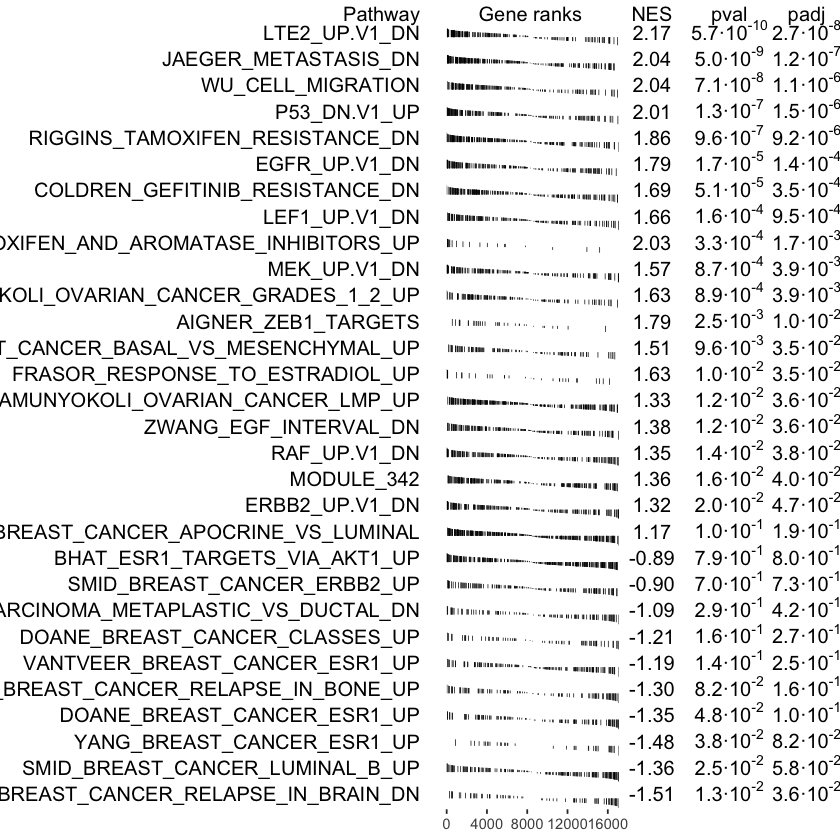

In [133]:
fgsea_in_estrogen <- fgsea(pathway = pathways_in_estrogen, stats=ranks, minSize=10, maxSize=300)

topPathwaysUp <- fgsea_in_estrogen[ES > 0][head(order(pval), n=20), pathway]
topPathwaysDown <- fgsea_in_estrogen[ES < 0][head(order(pval), n=20), pathway]
topPathways <- c(topPathwaysUp, rev(topPathwaysDown))
plotGseaTable(pathways_in_estrogen[topPathways], ranks, fgsea_in_estrogen, 
              gseaParam=0.5, colwidths = c(20, 8, 3, 4, 3))

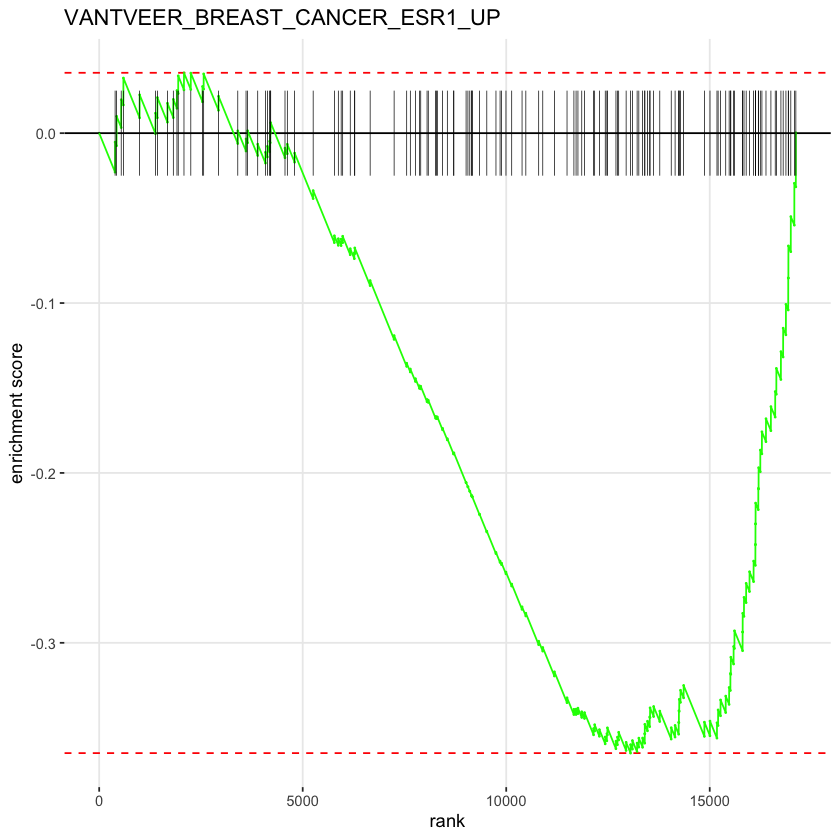

In [104]:
plotEnrichment(vantveer_up[["VANTVEER_BREAST_CANCER_ESR1_UP"]],
               ranks) + labs(title="VANTVEER_BREAST_CANCER_ESR1_UP")

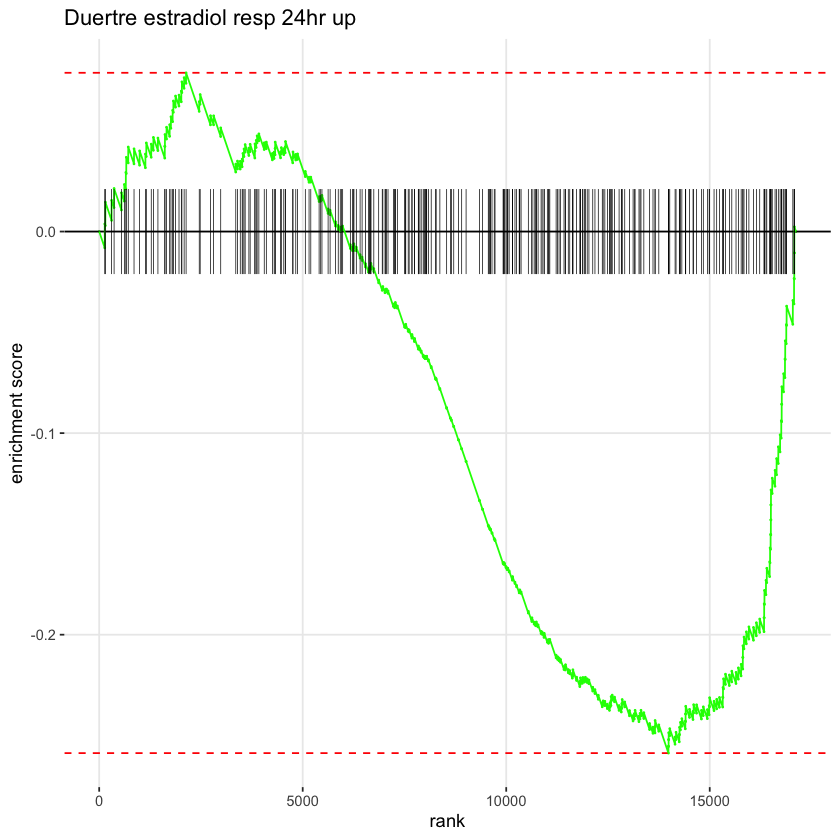

In [105]:
plotEnrichment(pathways_kahn[["Duertre estradiol resp 24hr up"]],
               ranks) + labs(title="Duertre estradiol resp 24hr up")